Then we try to solve the following ODE for harmonic oscillator:

$$\dfrac{d^2x}{dt^2}=-\omega^2 x, x(t=t_0)=x_0, \dfrac{dx}{dt}(t=t_0)=x_0^{'}$$

This problem can be formulated as a machine learning problem where the training examples are

$$(t_i, -\omega^2 x_i), i \in \{1, 2, ..., N\}$$

and the loss function is

$$\mathcal{L}(\text{NN})=(\dfrac{d^2x}{dt^2}+\omega^2 x)^2$$

where NN is the transformation learned by a neural network. We can enforce the initial condition $x(t=t_0)=x_0, \dfrac{dx}{dt}(t=t_0)=x_0^{'}$ by setting

$$x = x_0 + (t-t_0)x_0^{'} + (t-t_0)^2\text{NN}(t)$$ or $$x = x_0 + (t-t_0)x_0^{'} + (1-e^{t-t_0})^2\text{NN}(t)$$

at the output layer of the network.

In [1]:
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torch.autograd      as autograd

import numpy as np
import matplotlib.pyplot   as plt

from scipy.integrate import odeint

In [2]:
class FCNN(nn.Module):
    """
    A fully connected neural network.
    """
    def __init__(self, n_hidden_units, n_hidden_layers, condition, actv):
        """
        :param n_hidden_units: number of hidden units in each hidden layer
        :param n_hidden_layers: number of hidden layers
        :param condition: the initial condition of the ODE
        :param actv: the activation layer used in each hidden layer
        """
        super(FCNN, self).__init__()
        self.condition = condition
        layers = []
        layers.append(nn.Linear(1, n_hidden_units))
        layers.append(actv())
        for i in range(n_hidden_layers):
            layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            layers.append(actv())
        layers.append(nn.Linear(n_hidden_units, 1))
        self.NN = torch.nn.Sequential(*layers)

    def forward(self, t):
        x = self.NN(t)
        x = self.condition.enforce(t, x) # enforcing the initial condition
        return x

In [3]:
class Condition:
    def __init__(self, t_0, x_0, x_0_prime=None):
        self.t_0, self.x_0, self.x_0_prime = t_0, x_0, x_0_prime
    def enforce(self, t, x):
#         return self.x_0 + (t-self.t_0)*self.x_0_prime + ((t-self.t_0)**2)*x
        if self.x_0_prime: 
            return self.x_0 + (t-self.t_0)*self.x_0_prime + ( (1-torch.exp(-t+self.t_0))**2 )*x
        else:
            return self.x_0 + (1-torch.exp(-t+self.t_0))*x

In [4]:
class ExampleGenerator:
    def __init__(self, size, t_min=0.0, t_max=1.0, method='uniform'):
        self.size = size
        self.t_min, self.t_max = t_min, t_max
        if   method=='uniform':
            self.get_examples = lambda: torch.rand(self.size, requires_grad=True)*(self.t_max-self.t_min) + self.t_min
        elif method=='equally-spaced':
            self.examples = torch.linspace(self.t_min, self.t_max, self.size, requires_grad=True)
            self.get_examples = lambda: self.examples
        elif method=='equally-spaced-noisy':
            self.examples = torch.linspace(self.t_min, self.t_max, self.size, requires_grad=True)
            self.noise_mean = torch.zeros(self.size)
            self.noise_std  = torch.ones(self.size) * ( (t_max-t_min)/size ) / 4.0
            self.get_examples = lambda: self.examples+torch.normal(mean=self.noise_mean, std=self.noise_std)
        else:
            raise ValueError(f'Unknown method: {method}')

In [5]:
def train(fcnn, ode, example_generator, optimizer, criterion, n_epochs, batch_size, epochper_plot=100):
    """
    Train a fully connected neural network to solve an ODE. It is hard coded to solve the ODE d^2x/dt^2 = -omega^2*x.
    The training is done using mini-batches.
    :param fcnn: a fully connected neural network
    :param examples: the set of ts to train the neural network on
    :param optimizer: a optimizer from pytorch.optim
    :param criterion: a loss function from pytorch.nn
    :param n_epochs: the number of passes through the training set
    :param batch_size: the size of the minibatch
    """
    
    ################################## for plotting ##################################
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ts = np.linspace(example_generator.t_min, example_generator.t_max, 100)
    t_in_plot  = torch.linspace(example_generator.t_min, example_generator.t_max, 100, 
                                requires_grad=True).reshape((-1, 1, 1))
    ##################################################################################
    
    n_examples = example_generator.size
    if n_examples%batch_size != 0:
        # todo: I know this is stupid, I'll fix this later
        raise RuntimeError('Please choose a batch_size such that it is a factor of the size of the training set.')
    n_batches = n_examples//batch_size
    
    loss_history = np.zeros(n_epochs)
    
    for epoch in range(n_epochs):
        loss_epoch = 0.0

        examples = example_generator.get_examples()
        t_in_batches = examples.reshape((n_batches, batch_size, 1))
        for t_in in t_in_batches:
            
#             # add noise to weights
#             with torch.no_grad():
#                 for param in fcnn.parameters():
#                     param.add_(torch.randn(param.size()) * 0.0001)        

            x_out = fcnn(t_in)
            
            left, right = ode(x_out, t_in)
            loss = criterion(left, right)
            loss_epoch += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_history[epoch] = loss_epoch/n_batches
        
        ################################## for plotting ##################################
        if epoch%epochper_plot == 0:
            x_out = fcnn( t_in_plot )
            left, right = ode(x_out, t_in_plot, requires_grad=False)
            left, right = left.detach().numpy().flatten(), right.detach().numpy().flatten()
            xs = x_out.detach().numpy().flatten()
            
            ax1.clear()
            ax1.plot(ts, xs,    label='x(t) by NN')
            ax1.plot(ts, left,  label='left-hand  side of ODE')
            ax1.plot(ts, right, label='right-hand side of ODE')
            ax1.legend()
            ax1.set_title('solutions')
            
            ax2.clear()
            ax2.plot(loss_history)
            ax2.set_title('loss during training')
            ax2.set_ylabel('loss')
            ax2.set_xlabel('epochs')
            ax2.set_yscale('log')
            
            fig.canvas.draw()
        ##################################################################################
    
    return loss_history

<IPython.core.display.Javascript object>


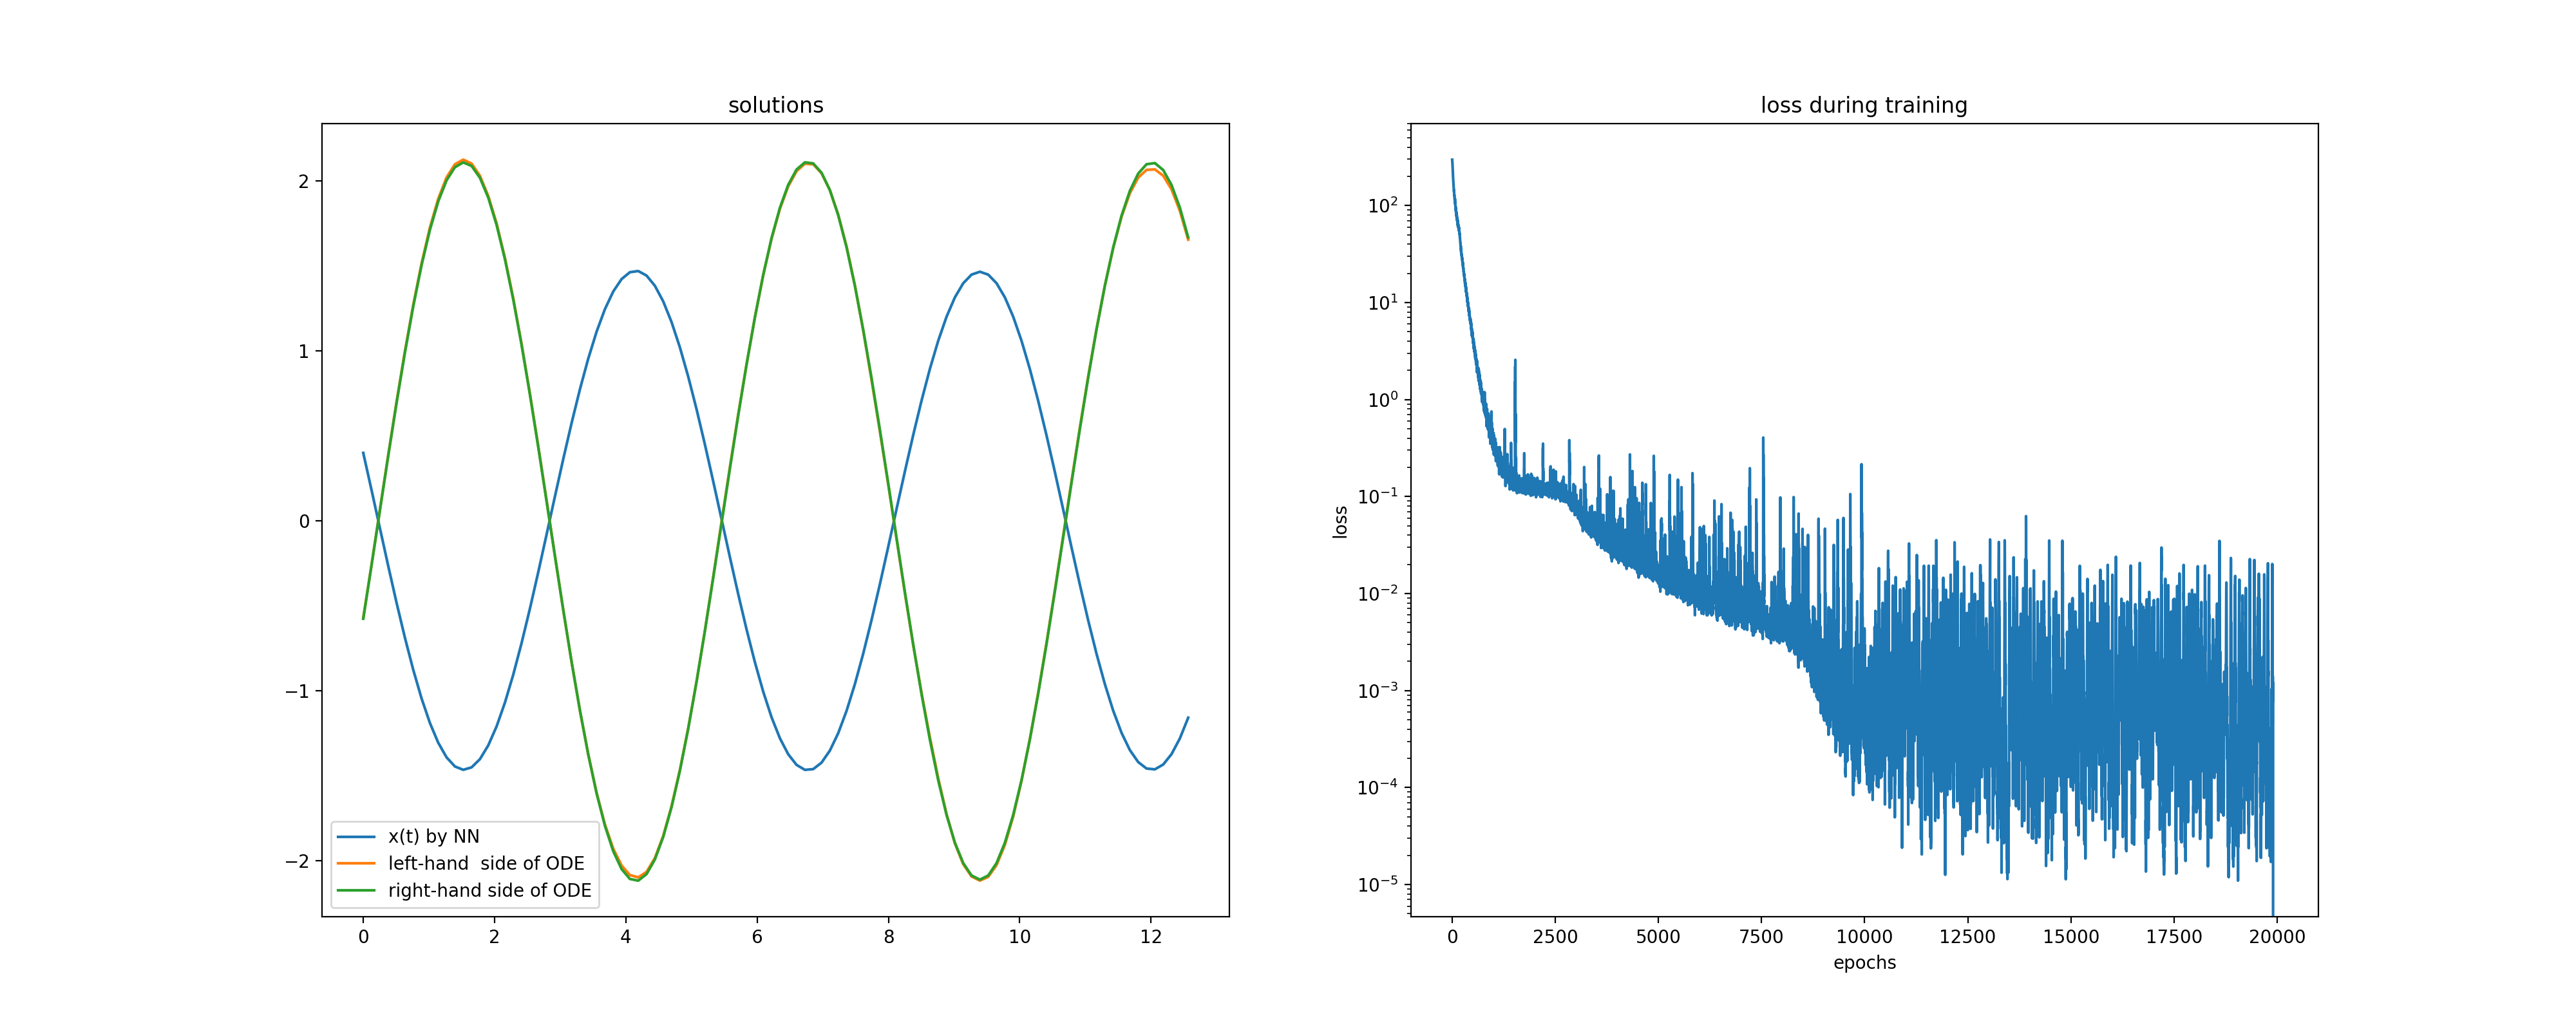

In [6]:
omega               = 1.2
t_0, x_0, x_0_prime = 0.0, 0.4, -1.7
t_min, t_max        = 0.0, 4*np.pi
actv                = nn.Tanh

def harmonic_oscillator_ode(x, t, omega=omega, requires_grad=True):
    mask = torch.ones_like(t)
    dxdt,   = autograd.grad(x,    t, create_graph=True,          grad_outputs=mask)
    d2xdt2, = autograd.grad(dxdt, t, create_graph=requires_grad, grad_outputs=mask)
    return d2xdt2, -(omega**2)*x
ode=harmonic_oscillator_ode

initial_condition = Condition(t_0=t_0, x_0=x_0, x_0_prime=x_0_prime)
fcnn = FCNN(n_hidden_units=32, n_hidden_layers=3, condition=initial_condition, actv=actv)
example_generator = ExampleGenerator(32, t_min, t_max, method='equally-spaced-noisy')
optimizer = optim.Adam(fcnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

%matplotlib notebook
loss_history = train(fcnn, ode=ode, 
                     example_generator=example_generator, optimizer=optimizer, criterion=criterion,
                     n_epochs=20000, batch_size=16)

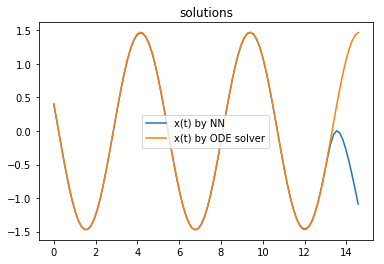

In [7]:
t_min_plot, t_max_plot = t_min, t_max+2

ts = np.linspace(t_min_plot, t_max_plot, 100)
t_in  = torch.linspace(t_min_plot, t_max_plot, 100, requires_grad=True).reshape((-1, 1, 1))
xs = fcnn( torch.linspace(t_min_plot, t_max_plot, 100).reshape((-1, 1, 1)) )\
     .detach().numpy().flatten()

def deriv(u, t, omega):
    x, x_prime = u
    return [x_prime, -(omega**2) * x]
xs_num = odeint(deriv, [x_0, x_0_prime], ts, args=(omega,))[:, 0]

%matplotlib inline
plt.figure()
plt.plot(ts, xs,     label='x(t) by NN')
plt.plot(ts, xs_num, label='x(t) by ODE solver')
plt.legend()
plt.title('solutions')
plt.show()

$$\frac{dx}{dt} = \lambda{x}$$

<IPython.core.display.Javascript object>


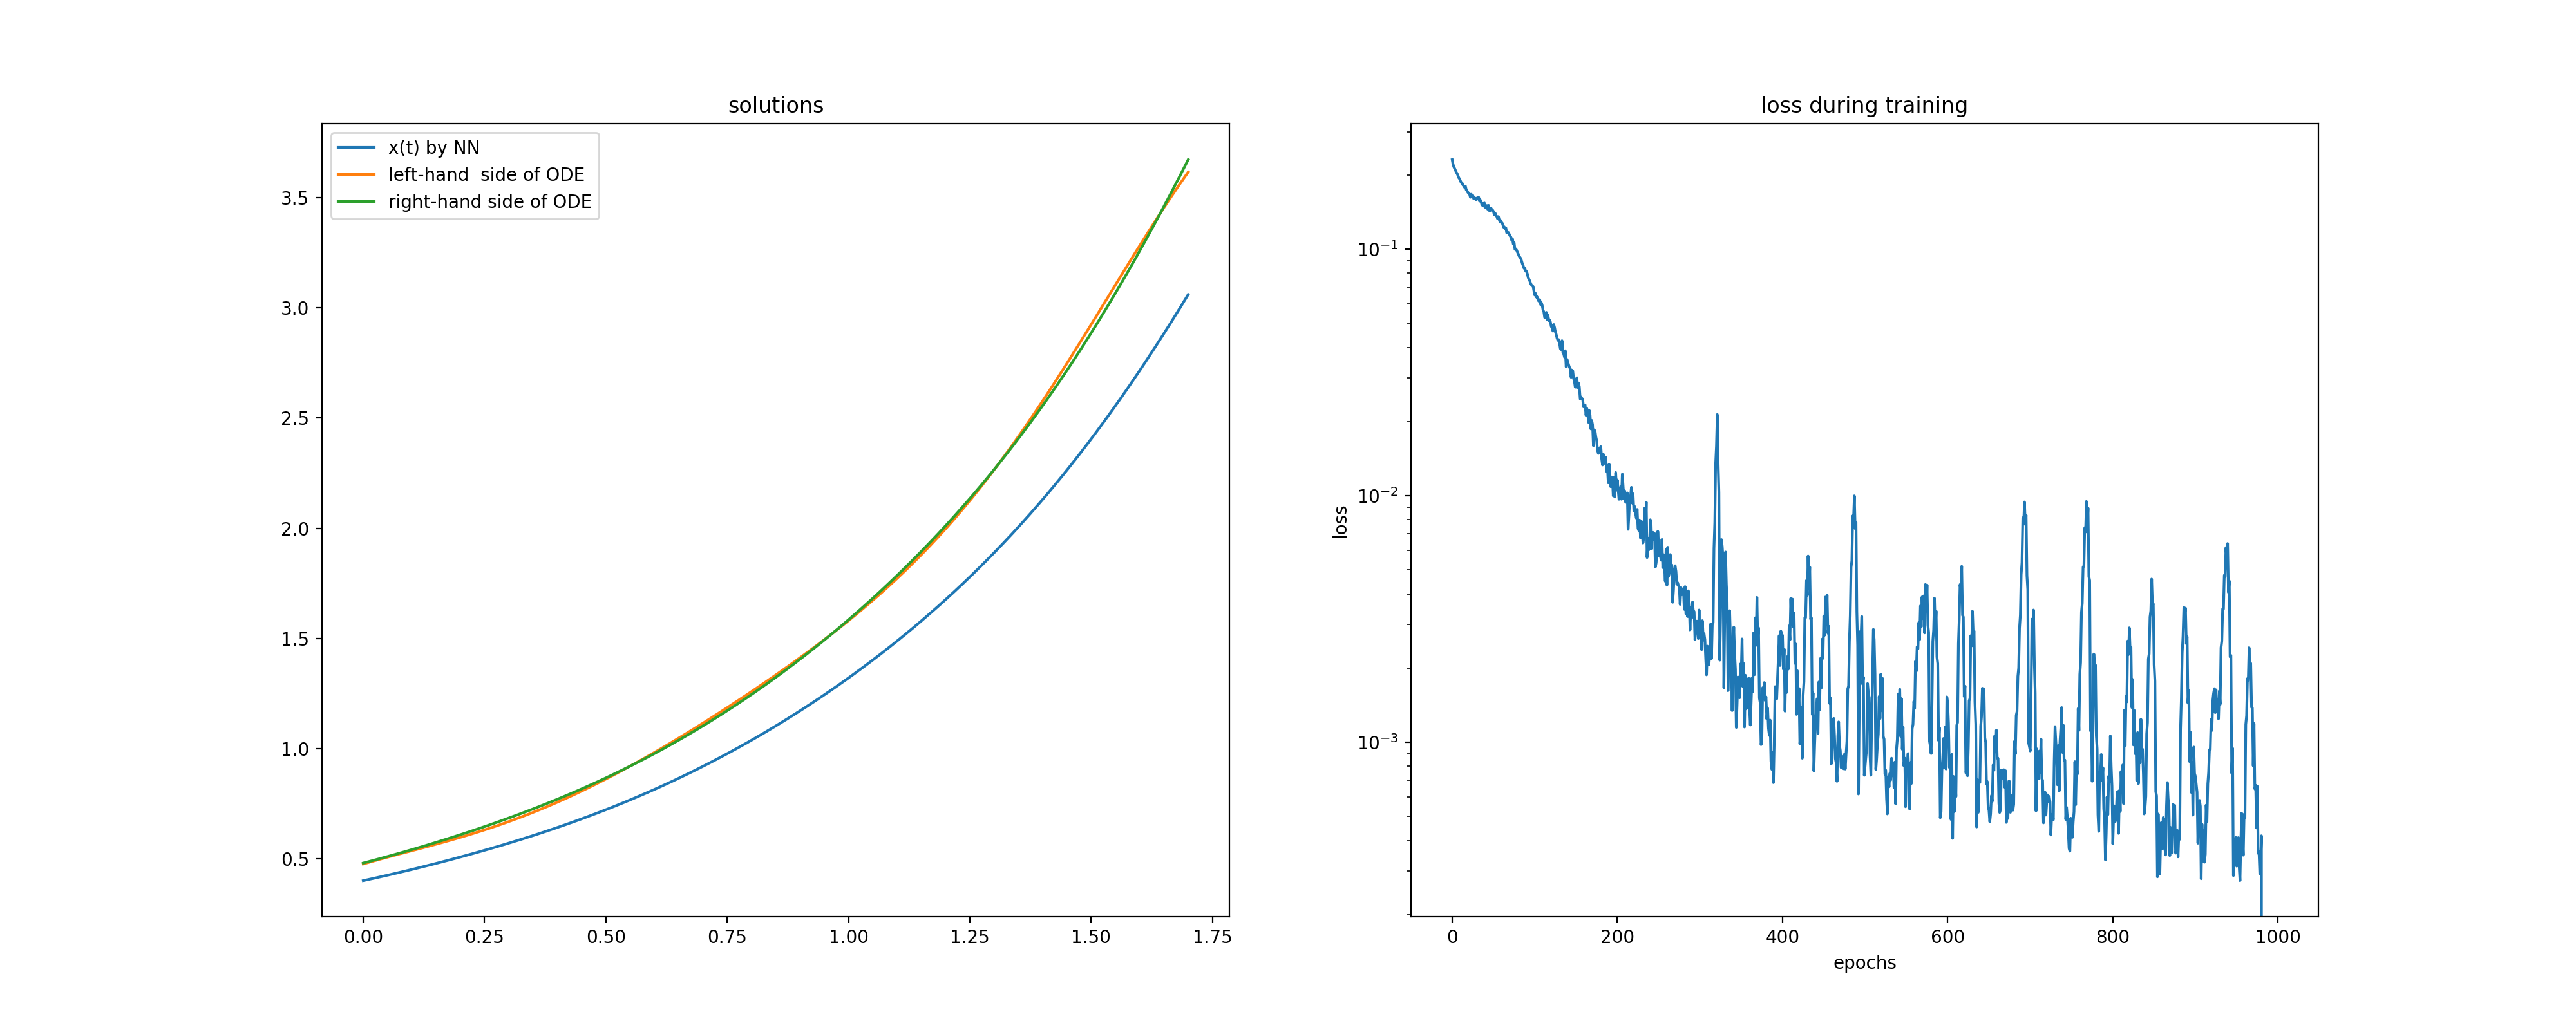

In [8]:
lambda_      = 1.2
t_0, x_0     = 0.0, 0.4
t_min, t_max = 0.0, 1.7
actv         = nn.Tanh

def dxdtlambdax_ode(x, t, lambda_=lambda_ , requires_grad=True):
    dxdt, = autograd.grad(x, t, create_graph=True, grad_outputs=torch.ones_like(t))
    return dxdt, lambda_*x
ode=dxdtlambdax_ode

initial_condition = Condition(t_0=t_0, x_0=x_0)
fcnn = FCNN(n_hidden_units=32, n_hidden_layers=3, condition=initial_condition, actv=actv)
example_generator = ExampleGenerator(32, t_min, t_max, method='equally-spaced-noisy')
optimizer = optim.Adam(fcnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

%matplotlib notebook
loss_history = train(fcnn, ode=ode, 
                     example_generator=example_generator, optimizer=optimizer, criterion=criterion,
                     n_epochs=1000, batch_size=16, epochper_plot=20)

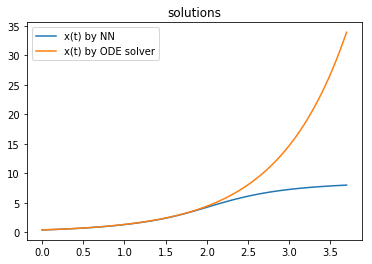

In [9]:
t_min_plot, t_max_plot = t_min, t_max+2

ts = np.linspace(t_min_plot, t_max_plot, 100)
t_in  = torch.linspace(t_min_plot, t_max_plot, 100, requires_grad=True).reshape((-1, 1, 1))
xs = fcnn( torch.linspace(t_min_plot, t_max_plot, 100).reshape((-1, 1, 1)) )\
     .detach().numpy().flatten()

def deriv(u, t, lambda_):
    x, = u
    return [lambda_*x]
xs_num = odeint(deriv, [x_0, ], ts, args=(lambda_,))[:, 0]

%matplotlib inline
plt.figure()
plt.plot(ts, xs,     label='x(t) by NN')
plt.plot(ts, xs_num, label='x(t) by ODE solver')
plt.legend()
plt.title('solutions')
plt.show()

$$\frac{d^2x}{dt^2} = \frac{F(t)}{m} - 2\omega\zeta\frac{dx}{dt} - \omega^2 t$$

<IPython.core.display.Javascript object>


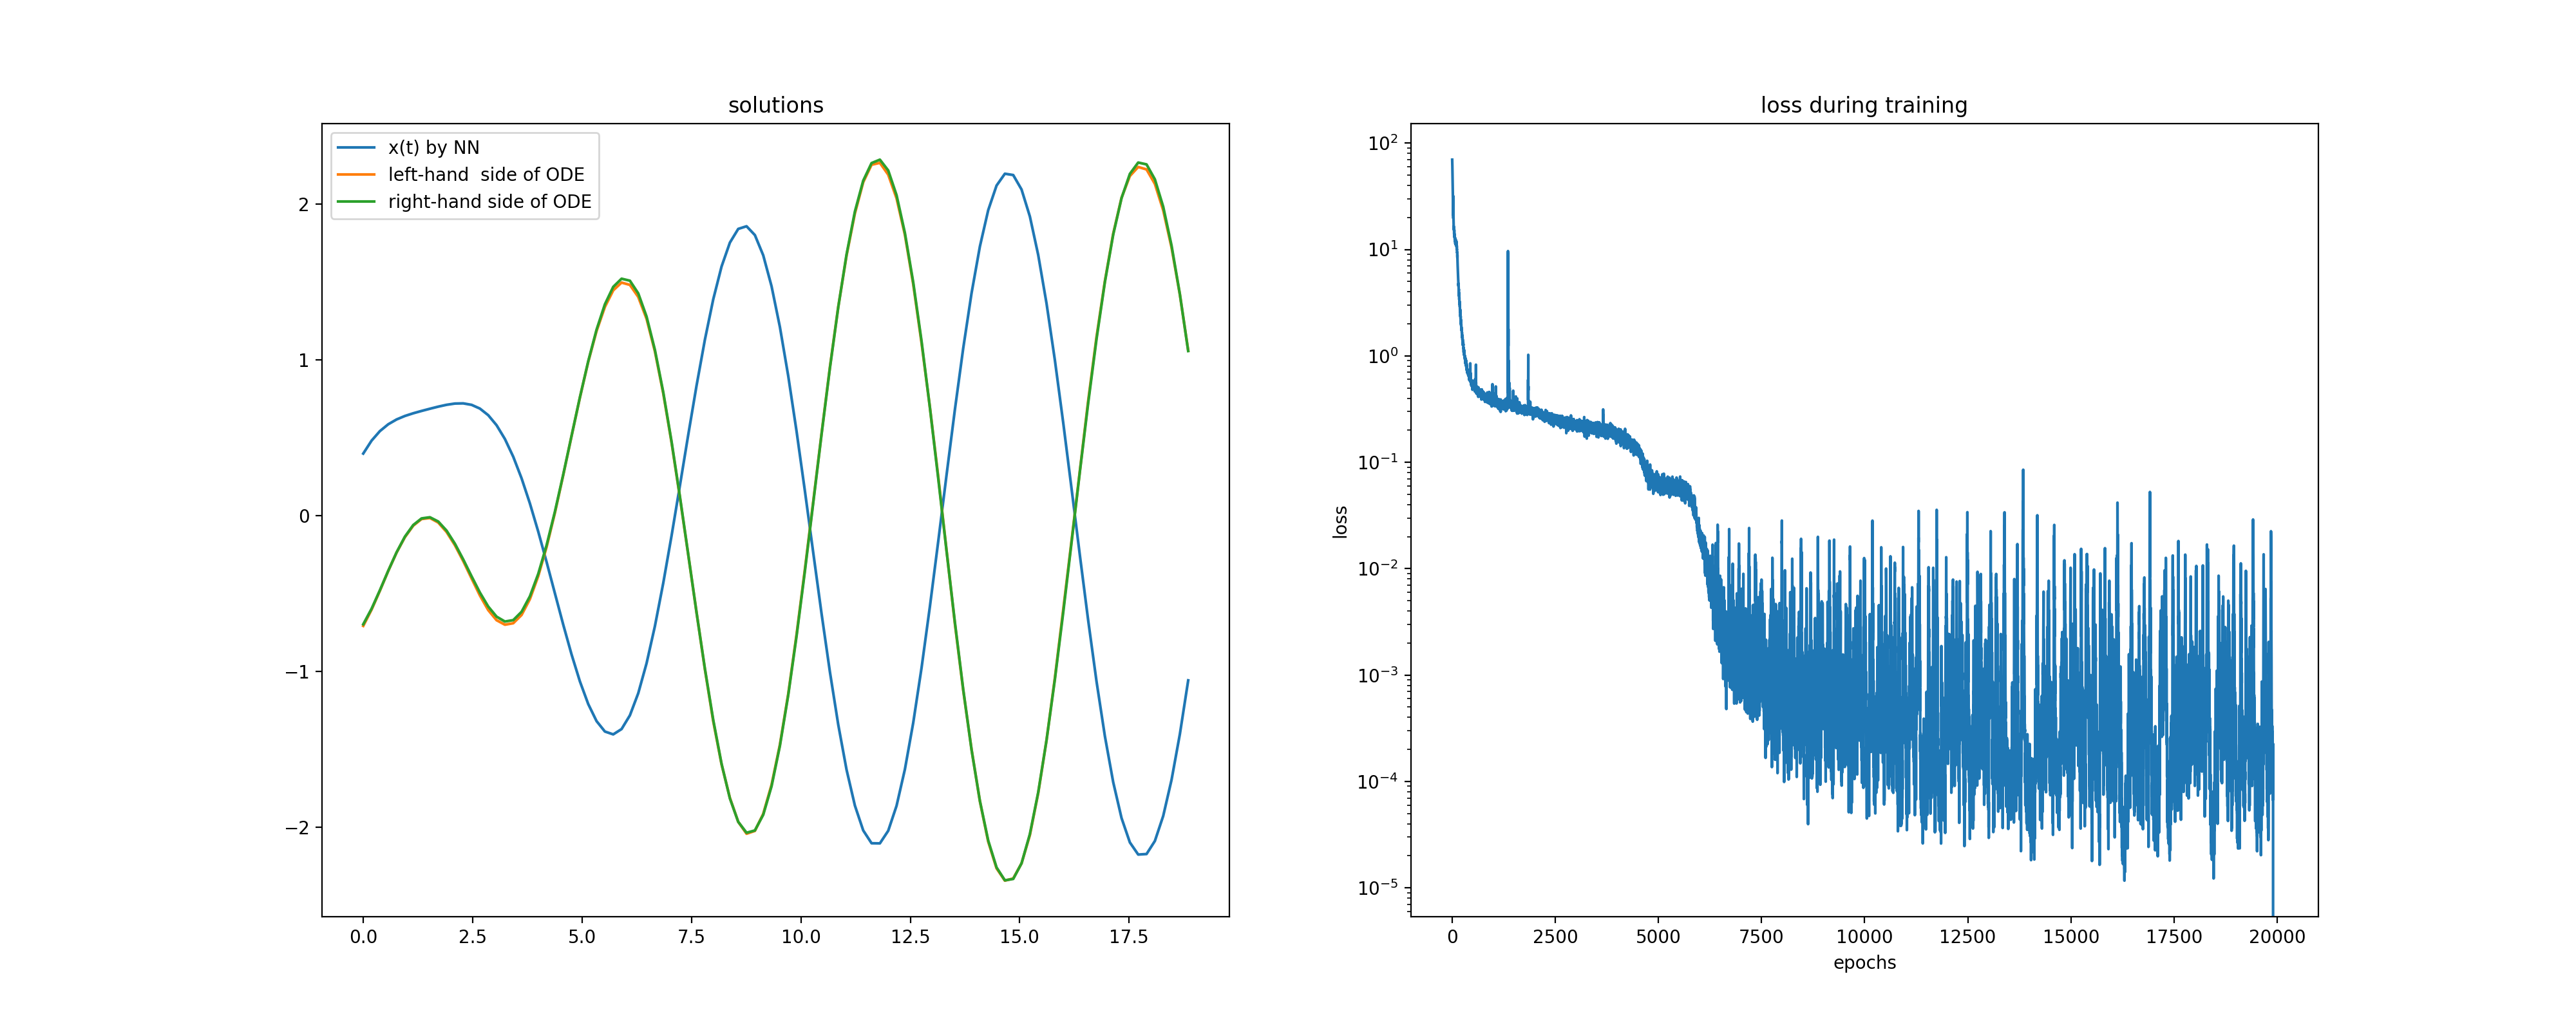

In [10]:
omega     = 1.2
zeta      = 0.1
F_over_m  = lambda t: torch.sin(t)
t_0, x_0, x_0_prime = 0.0, 0.4, 0.5
t_min, t_max = 0.0, 6*np.pi
actv         = nn.Tanh

def driven_oscillator_ode(x, t, omega=omega, zeta=zeta, F_over_m=F_over_m, requires_grad=True):
    mask = torch.ones_like(t)
    dxdt,   = autograd.grad(x,    t, create_graph=True,          grad_outputs=mask)
    d2xdt2, = autograd.grad(dxdt, t, create_graph=requires_grad, grad_outputs=mask)
    return d2xdt2, F_over_m(t) - 2*omega*zeta*dxdt - (omega**2)*x
ode=driven_oscillator_ode

initial_condition = Condition(t_0=t_0, x_0=x_0, x_0_prime=x_0_prime)
fcnn = FCNN(n_hidden_units=32, n_hidden_layers=3, condition=initial_condition, actv=actv)
example_generator = ExampleGenerator(32, t_min, t_max, method='equally-spaced-noisy')
optimizer = optim.Adam(fcnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

%matplotlib notebook
loss_history = train(fcnn, ode=ode, 
                     example_generator=example_generator, optimizer=optimizer, criterion=criterion,
                     n_epochs=20000, batch_size=16)

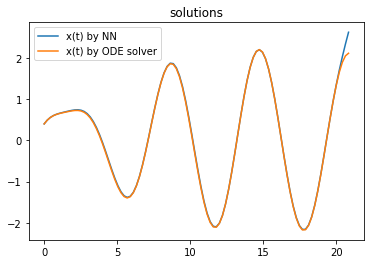

In [12]:
t_min_plot, t_max_plot = t_min, t_max+2

ts = np.linspace(t_min_plot, t_max_plot, 100)
t_in  = torch.linspace(t_min_plot, t_max_plot, 100, requires_grad=True).reshape((-1, 1, 1))
xs = fcnn( torch.linspace(t_min_plot, t_max_plot, 100).reshape((-1, 1, 1)) )\
     .detach().numpy().flatten()

def deriv(u, t, omega, zeta, F_over_m):
    x, x_prime = u
    return [x_prime, F_over_m(torch.tensor(t)).detach().numpy() - 2*omega*zeta*x_prime - (omega**2) * x]
xs_num = odeint(deriv, [x_0, x_0_prime], ts, args=(omega, zeta, F_over_m,))[:, 0]

%matplotlib inline
plt.figure()
plt.plot(ts, xs,     label='x(t) by NN')
plt.plot(ts, xs_num, label='x(t) by ODE solver')
plt.legend()
plt.title('solutions')
plt.show()